In [1]:
import sys
from pathlib import Path
path_root = '../'
sys.path.append(str(path_root))

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from one.api import ONE
from brainbox.io.one import SessionLoader, SpikeSortingLoader
from iblatlas.atlas import AllenAtlas
from utils.ibl_data_utils import (
    load_spiking_data,
    load_anytime_behaviors,
    prepare_data, 
    select_brain_regions, list_brain_regions, 
    create_intervals, bin_spiking_data, bin_behaviors
)
from utils.dataset import create_dataset, upload_dataset, download_dataset, get_binned_spikes_from_sparse

/home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/neurodsp/__init__.py:5: FutureWarning: neurodsp has been renamed to ibldsp and the old name will be deprecated on 01-Sep-2024.
  warn(


##### Data Loading Example (Single Session)

In [2]:
# Instantiate ONE
one = ONE(
    base_url='https://openalyx.internationalbrainlab.org', 
    password='international', silent=True
)
ba = AllenAtlas()

In [3]:
# List all publicly available sessions
# sessions = one.search()

# List all sessions from the brain-wide-map project
# Note: Not all sessions will have behaviors recorded so we can use sessions 
#       w/ behaviors for supervised tasks and those w/o for SSL
# sessions = one.search(project='brainwide')

# List brainwide map sessions that pass the most important quality controls
# Note: Let's first work with these good quality sessions, and 
#       transition to using more sessions later on
freeze_file = '../data/2023_12_bwm_release.csv'
bwm_df = pd.read_csv(freeze_file, index_col=0)

In [4]:
# Load an example session
idx = 10
pid = bwm_df.pid[idx]
eid, probe = one.pid2eid(pid)

In [5]:
idx = (bwm_df.eid.unique() == eid).argmax()
eid = bwm_df.eid.unique()[idx]
tmp_df = bwm_df.set_index(['eid', 'subject']).xs(eid, level='eid')
subject = tmp_df.index[0]

In [6]:
# Load spike sorting data
spikes, clusters = load_spiking_data(one, pid)

In [7]:
# Load behaviors for any-time decoding
anytime_behaviors = load_anytime_behaviors(one, eid)
print(anytime_behaviors.keys())

dict_keys(['wheel-position', 'wheel-velocity', 'wheel-speed', 'left-whisker-motion-energy', 'right-whisker-motion-energy', 'left-pupil-diameter', 'right-pupil-diameter', 'left-camera-left-paw-speed', 'left-camera-right-paw-speed', 'right-camera-left-paw-speed', 'right-camera-right-paw-speed', 'left-nose-speed', 'right-nose-speed'])


##### Prepare Data for Any-Time Decoding (Single Session)

In [8]:
params = {
    # setup for using the full recording (need it for pretraining)
    'interval_len': 2,
    'binsize': 0.02,
    # use all available regions
    'single_region': False, 
    # setup for using recording segments within trials (only need it for fine-tuning)
    'align_time': 'stimOn_times',
    'time_window': (-.5, 1.5),
}

In [9]:
neural_dict, behave_dict, meta_data, trials_data = prepare_data(one, eid, bwm_df, params)

Merged 2 probes for session eid: 8c33abef-3d3e-4d42-9f27-445e9def08f9


##### Prepare Data for Trial Decoding (Single Session)

In [10]:
regions, beryl_reg = list_brain_regions(neural_dict, **params)

Use spikes from brain regions:  ['BST' 'CP' 'MEA' 'MOp' 'RT' 'VPL' 'root']


In [11]:
region_cluster_ids = select_brain_regions(neural_dict, beryl_reg, regions, **params)

In [12]:
intervals = create_intervals(
    start_time=0, end_time=neural_dict['spike_times'].max(), interval_len=params['interval_len']
)

In [13]:
binned_spikes, clusters_used_in_bins = bin_spiking_data(
    region_cluster_ids, neural_dict, intervals=intervals, **params
)

100%|███████████████████████████████████████| 3007/3007 [02:14<00:00, 22.42it/s]


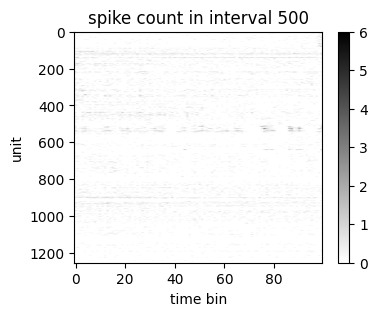

In [14]:
interval_idx = 500
plt.figure(figsize=(4,3))
plt.imshow(binned_spikes[interval_idx].T, aspect="auto", cmap="binary")
plt.title(f"spike count in interval {interval_idx}")
plt.xlabel("time bin")
plt.ylabel("unit")
plt.colorbar();

In [15]:
total_elems = binned_spikes[interval_idx].shape[0] * binned_spikes[interval_idx].shape[1]
nonzero_elems = np.count_nonzero(binned_spikes[interval_idx])
print(f"sparsity: {nonzero_elems / total_elems:.2f}")

sparsity: 0.05


In [16]:
binned_behaviors = bin_behaviors(
    one, eid, trials_only=False, intervals=intervals, allow_nans=True, **params
)
binned_behaviors.keys()

dict_keys(['wheel-position', 'wheel-velocity', 'wheel-speed', 'left-whisker-motion-energy', 'right-whisker-motion-energy', 'left-pupil-diameter', 'right-pupil-diameter', 'left-camera-left-paw-speed', 'left-camera-right-paw-speed', 'right-camera-left-paw-speed', 'right-camera-right-paw-speed', 'left-nose-speed', 'right-nose-speed'])

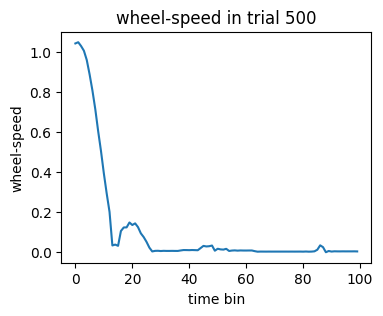

In [17]:
behave = "wheel-speed"
plt.figure(figsize=(4,3))
plt.plot(binned_behaviors[behave][interval_idx])
plt.title(f"{behave} in trial {interval_idx}")
plt.xlabel("time bin")
plt.ylabel(behave);

## Save Dataset

In [26]:
dataset = create_dataset(binned_spikes, bwm_df, eid, params, meta_data=meta_data, binned_behaviors=None)
upload_dataset(dataset)

## Download and Test Dataset

In [ ]:
dataset = download_dataset()

In [24]:
dataset

Dataset({
    features: ['spikes_sparse_data', 'spikes_sparse_indices', 'spikes_sparse_indptr', 'spikes_sparse_shape', 'binsize', 'interval_len', 'eid', 'probe_name', 'subject', 'lab', 'cluster_regions', 'cluster_channels', 'good_clusters'],
    num_rows: 3007
})

In [28]:
spikes_sparse_data_list = dataset['spikes_sparse_data']
spikes_sparse_indices_list = dataset['spikes_sparse_indices']
spikes_sparse_indptr_list = dataset['spikes_sparse_indptr']
spikes_sparse_shape_list = dataset['spikes_sparse_shape']

downloaded_binned_spikes = get_binned_spikes_from_sparse(spikes_sparse_data_list, spikes_sparse_indices_list, spikes_sparse_indptr_list, spikes_sparse_shape_list)

print(f"Shape of downloaded binned spikes: {downloaded_binned_spikes.shape}. Shape of original binned spikes: {binned_spikes.shape}")

Shape of downloaded binned spikes: (3007, 100, 1255). Shape of original binned spikes: (3007, 100, 1255)
